# Binary Image Classifier: Crack Detection

## Imports

This program demostrates the use of the FastAI deep learning library, which is built on top of PyTorch. The FastAI library is a high-level library that simplifies much of the complexity of PyTorch, making it much easier to train and deploy deep learning AI models. The FastAI library provides a number of pre-trained models that can be used for **transfer learning**, which is a technique that allows you to use a pre-trained model as a starting point for training a new model on a different dataset. Such is the case in this example.

In [1]:
from fastai.vision.all import *

## Data Preprocessing

The following code utilizes the DataBlock function from the FastAI library to preprocess the data. The DataBlock function allows you to define how your data should be loaded, transformed, and split into training and validation sets. In this case, the DataBlock function is used to load the images from the dataset, apply data augmentation, and split the data into training and validation sets.

In [2]:
path = Path('concrete-dataset')

datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

dls = datablock.dataloaders(path)

Code Explainations:

| Line | Explanation |
|------|-------------|
| `path = Path('concrete-dataset')` | This line creates a `Path` object pointing to the directory 'concrete-dataset'. `Path` is typically used for file and directory path manipulations. |
| `datablock = DataBlock(` | Initializes a `DataBlock`, an API in fastai for building datasets. |
| `blocks=(ImageBlock, CategoryBlock),` | Defines the types of data blocks: `ImageBlock` for input images and `CategoryBlock` for output categories (labels). |
| `get_items=get_image_files,` |  `get_image_files` is a function that retrieves image files. |
| `splitter=RandomSplitter(valid_pct=0.2, seed=42),` | Sets up a random splitter for dividing the dataset into training and validation sets. `valid_pct=0.2` means 20% of the data is used for validation, and `seed=42` ensures reproducibility of the split. |
| `get_y=parent_label,` | Defines how to label the data. `parent_label` labels items based on their parent directory name. In this case the dataset is divided into two folders(binary) "cracked" and "uncracked" for classification. |
| `item_tfms=Resize(460),` | Transformation to resize each image to 460 pixels. |
| `batch_tfms=aug_transforms(size=224, min_scale=0.75)` | `aug_transforms` applies data augmentation (random modifications) to the images, resizing them to 224 pixels with a minimum scale of 0.75. |
| `dls = datablock.dataloaders(path)` | `dls` is a variable for which the output `datablock` in an instance of the previously configured `DataBlock`, using the dataset defined by `path`. `dataLoaders` is a function of the `DataBlock` class. This function(method) is used to turn the blueprint(class) into an object(instance of the class).|

The following line is used for data visualization and to check if the data is loading and that the lables for the dataset are correct.

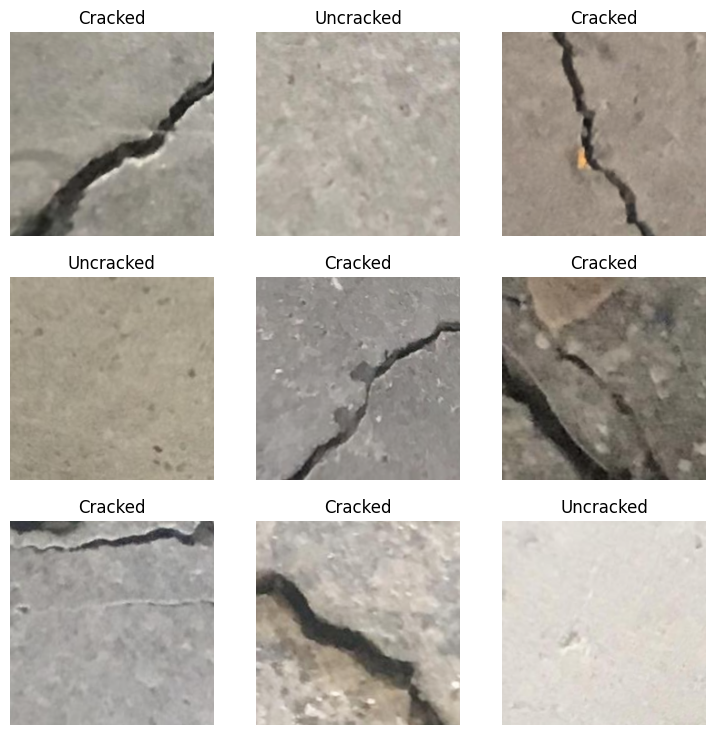

In [3]:
dls.show_batch(nrows=3, ncols=3)

## Model Training

This code utilizes the `vision_learner`  function from the FastAI library to train a convolutional neural network (CNN) on the preprocessed data. The `vision_learner` function allows you to create a CNN model and train it using the FastAI library. The `vision_learner` function also allows you to use transfer learning by specifying a pre-trained model to use as a starting point for training the new model. This enables the model to reach a very high degree of accuracy that would otherwise be difficult to achieve with a small dataset.

`fit_one_cycle` This line trains the model for 4 epochs using the fit_one_cycle function, a technique that adjusts the learning rate and momentum during training for improved model performance and faster convergence.

`learn.show_results` This line displays the results of the model training, including the loss and accuracy of the model on the training and validation sets.

`learn.export` This line saves the trained model to a file, which can be loaded and used for making predictions on new data.

epoch,train_loss,valid_loss,accuracy,time
0,0.018340,0.004682,0.999000,00:47
1,0.015062,0.002358,0.999250,00:45
2,0.010042,0.000899,0.999750,00:45
3,0.007102,0.001186,0.999250,00:46


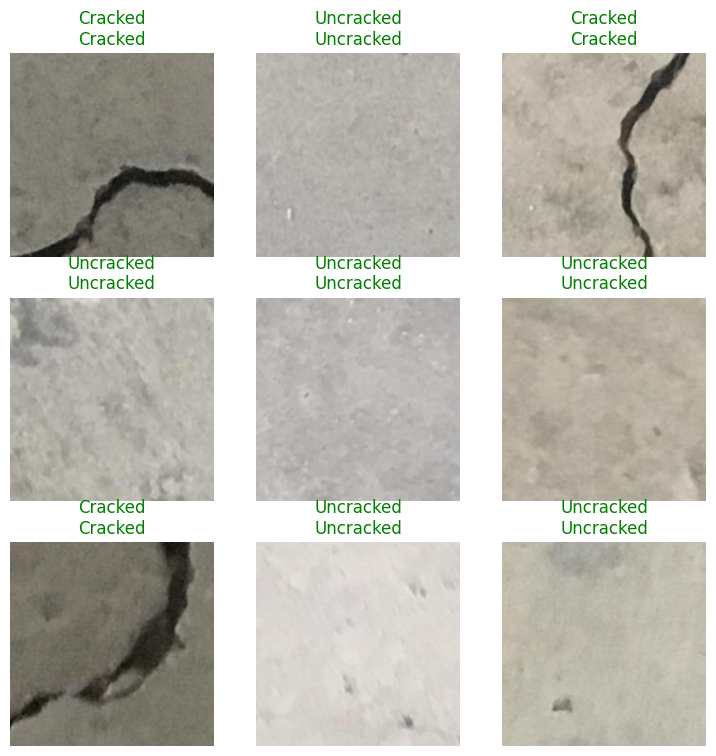

In [10]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fit_one_cycle(4)
learn.show_results()
learn.export('concrete_classifier.pkl')

## Model Evaluation

This code utilizes the `ClassificationInterpretation` class from the FastAI library to evaluate the trained model. The `ClassificationInterpretation` class allows you to generate a confusion matrix, plot the most confused classes, and plot the top losses. This information can be used to gain insights into how the model is performing and identify areas for improvement.

In [5]:
# Validate the model and return the loss and metrics
val_loss, *metrics = learn.validate()
print(f'Validation loss: {val_loss}')
for metric, value in zip(learn.metrics, metrics):
    print(f'{metric.name}: {value}')

Validation loss: 0.0010906553361564875
accuracy: 0.9994999766349792


| Line | Description |
|------|-------------|
| `val_loss, *metrics = learn.validate()` | This line runs the validation process on the trained model. `learn.validate()` returns the validation loss and any other metrics specified from the validation dataset. Again, the validation set is the previously defined portiong (20 percent) of the original dataset that is set aside for testing the performance of the trained model. |
| `print(f'Validation loss: {val_loss}')` | Prints the validation loss, which is a measure of the model's performance on the validation dataset. A lower loss indicates better performance. |
| `for metric, value in zip(learn.metrics, metrics):` | This loop iterates through each metric defined in the learner. `learn.metrics` contains the metrics used during training, and `metrics` contains their corresponding values obtained from validation. |
| `print(f'{metric.name}: {value}')` | Prints the name of each metric and its corresponding value as obtained from the validation process. |

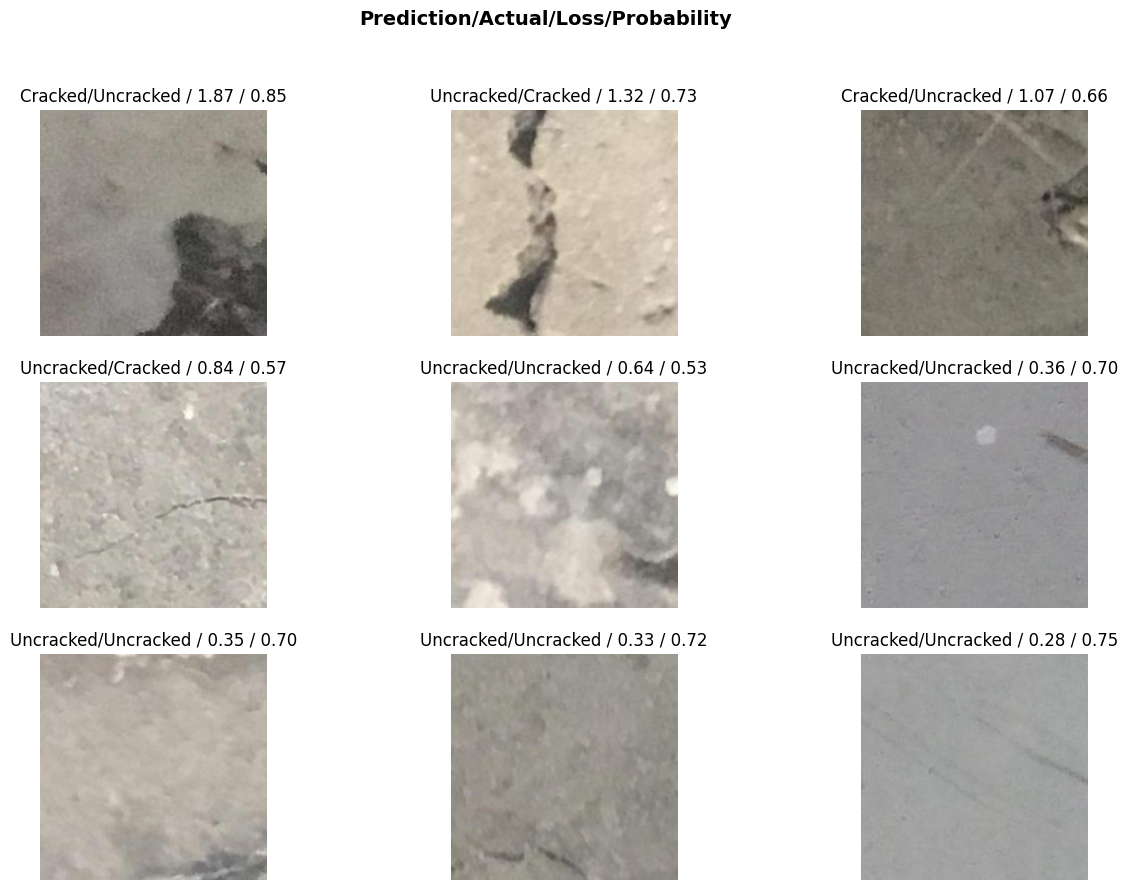

In [6]:
# Plot the top losses
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

This line plots the images with the highest loss value. In this case, the model has only misidentified 4 images, yielding an accraucy of 99.5% on the validation set. This is extremely good performance. 

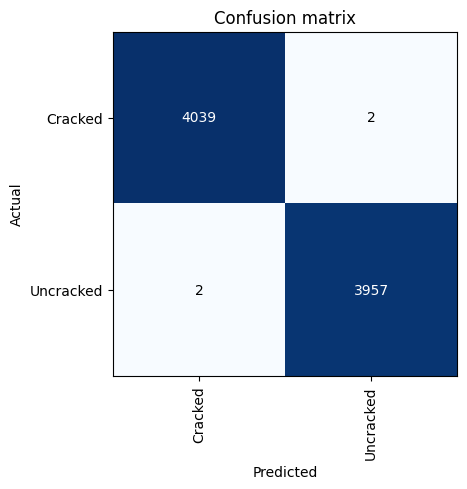

In [7]:
# Plot the confusion matrix
interp.plot_confusion_matrix()

Again, the confusion matrix verifies that the model has only made 4 total mistakes out of 8000 images.

In [11]:
# Get predictions and targets
preds, targets, decoded_preds = learn.get_preds(with_decoded=True)
# Confidence of predictions
confidences = preds.max(dim=1).values

Here, the first line retrievs predictions and targets from the model. The second line calculates the confidence level of each prediction. 

In [9]:
# Load the learner
learn = load_learner('concrete_classifier.pkl')

# Function to create a PILImage object
def get_image(image_path):
    return PILImage.create(image_path)

# Example usage:
image_path = 'images/concrete6.jpg'
img = get_image(image_path)

# Predict the image
pred, pred_idx, probs = learn.predict(img)
print(f'Prediction: {pred}; Probability: {probs[pred_idx]}')

Prediction: Uncracked; Probability: 0.9999983310699463


| Line | Description |
|------|-------------|
| `learn = load_learner('concrete_classifier.pkl')` | This line loads a the previously trained and saved `concrete_classifier` model. |
| `def get_image(image_path):` | The function retrieves an image from a given path, in this case from the 'images' folder in project directory. |
| `return PILImage.create(image_path)` | Loads an image in a suitable format.|
| `image_path = 'images/concrete6.jpg'` | Path to the test image. |
| `pred, pred_idx, probs = learn.predict(img)` | This line uses the loaded model (`learn`) to predict the class of the image stored in `img`. The `predict` function returns the predicted class (`pred`), the index of the predicted class (`pred_idx`), and the probabilities of all classes (`probs`). |
| `print(f'Prediction: {pred}; Probability: {probs[pred_idx]}')` | Finally, this line prints the predicted class along with the probability of that class. `probs[pred_idx]` indexes the probability corresponding to the predicted class from the `probs` array. |

The model predicts that the test image is that of an uncracked surface with a probability of 0.9999. This is a very high confidence level, indicating that the model is very certain of its prediction.